In [1]:
#importing libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print(tf.__version__)


2.14.0


In [2]:
from google.colab import drive
drive.mount('/content/drive') #mounting the Google Drive to the Colab virtual machine
file_found = '/content/drive/MyDrive/fraudTrain.csv'  #specifies the file path to the csv file

Mounted at /content/drive


Importing Datasets

In [3]:
data = pd.read_csv(file_found)  #reads the csv file into a pandas DataFrame
data = data.select_dtypes(exclude=['object']) #excludes strings takes only floats and intigers


In [4]:
data.shape  #gets the dimensions of the dataframe. There are 1296675 rows/transactions and 11 features

(1296675, 11)

In [5]:
data.head() #used to get the class/column/feature that does the binary classification (if its fraud 1->fraud; 0->non_fraud)

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0


In [6]:
data['is_fraud'].value_counts() #counts the occurrences of is_fraud feature

0    1289169
1       7506
Name: is_fraud, dtype: int64

Balance dataset

In [7]:
data.info() #gets the data type of each column/feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1296675 non-null  int64  
 1   cc_num      1296675 non-null  int64  
 2   amt         1296675 non-null  float64
 3   zip         1296675 non-null  int64  
 4   lat         1296675 non-null  float64
 5   long        1296675 non-null  float64
 6   city_pop    1296675 non-null  int64  
 7   unix_time   1296675 non-null  int64  
 8   merch_lat   1296675 non-null  float64
 9   merch_long  1296675 non-null  float64
 10  is_fraud    1296675 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 108.8 MB


In [8]:
non_fraud = data[data['is_fraud']==0] #contains the non-fraudlent data
fraud = data[data['is_fraud']==1] #contains the fraudlent data

In [9]:
non_fraud.shape, fraud.shape  #gets the dimensions of each dataframe

((1289169, 11), (7506, 11))

In [10]:
non_fraud = non_fraud.sample(fraud.shape[0])  #balancing the dataset by matching the non-fraudlent instances with the fraudlent
non_fraud.shape

(7506, 11)

In [11]:
data = fraud.append(non_fraud, ignore_index=True)   #combines both dataframes into a single one
data

<ipython-input-11-1a7d54f0052f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = fraud.append(non_fraud, ignore_index=True)   #combines both dataframes into a single one


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2449,4613314721966,281.06,28611,35.9946,-81.7266,885,1325466397,36.430124,-81.179483,1
1,2472,340187018810220,11.52,78208,29.4400,-98.4590,1595797,1325468849,29.819364,-99.142791,1
2,2523,340187018810220,276.31,78208,29.4400,-98.4590,1595797,1325473523,29.273085,-98.836360,1
3,2546,4613314721966,7.03,28611,35.9946,-81.7266,885,1325475483,35.909292,-82.091010,1
4,2553,340187018810220,275.73,78208,29.4400,-98.4590,1595797,1325476547,29.786426,-98.683410,1
...,...,...,...,...,...,...,...,...,...,...,...
15007,843523,342319985983023,59.79,12455,42.1852,-74.6178,1988,1355484753,41.869837,-75.148768,0
15008,991676,501899453424,29.39,35903,33.9845,-85.9077,67082,1360401480,33.329414,-85.201724,0
15009,522378,349612764943496,74.39,40914,37.1046,-83.5706,467,1344815451,37.324150,-83.913401,0
15010,32941,4378993458389626,4.79,3818,43.9742,-71.1503,3807,1327077620,43.045987,-71.481381,0


In [12]:
data['is_fraud'].value_counts()   #checking if the dataset is balanced

1    7506
0    7506
Name: is_fraud, dtype: int64

In [13]:
X = data.drop('is_fraud', axis = 1)   #contains all the features except the target(is_fraud)
y = data['is_fraud']  #contains the target variable

In [14]:
#spliting the list into train and test using train_test_split imported by the sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)  

In [15]:
#getting the shape of each train and test set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12009, 10), (3003, 10), (12009,), (3003,))

In [16]:
#applying scaling to the training and testing sets to bring all the features in a similar scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Comverting from Pandas to NumPy as TensorFlow expect NumPy arrays as we will need to use NumPy operations later
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [18]:
#creating the binary prediction
def y_pred_for_DLModels(CNN, X_test): #takes the model and X_test as inputs
    y_pred = CNN.predict(X_test)  # uses .predict() to obtain the predicted probabilities for each input
    y_pred_binary = (y_pred > 0.5).flatten()  #applying a threshold of 0.5 to the predicted probabilities, if pred>0,5 = positive, pred<0,5 = negative
    return y_pred_binary  #returns the prediction

In [19]:
#reshaping the sets as CNN takes 3 dimensional inputs
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
#checking the 3 dimensional X_train and X_test shape
X_train_reshaped.shape, X_test_reshaped.shape

((12009, 10, 1), (3003, 10, 1))

Build CNN

In [21]:
#creating the CNN architecture
epochs = 70 #the number of times the model will iterate through the training dataset during training
CNN = Sequential()  #creating a sequencial keras model,linear stack of layers
CNN.add(Conv1D(32, 2, activation='relu', input_shape = X_train_reshaped[0].shape))  #1D convonutional layer with 32 filter
CNN.add(BatchNormalization()) #accelerates and stabilazes the training by normalizing the inputs of a layer
CNN.add(Dropout(0.2)) #using dropout to avoid overfitting, ignoring 20% of randomly selected neurons

CNN.add(Conv1D(64, 2, activation='relu')) #convonutional layer with 64 filters
CNN.add(BatchNormalization())
CNN.add(Dropout(0.8)) #same proccess but now avoiding 80% of randomly selected neurons

CNN.add(Flatten())  #flattern layer to flattern the output of convonutional layer from 3D into 1D array before going to the Dense layers
CNN.add(Dense(64, activation='relu')) #dense layer with 64 neurons, helps to capture higher-level patterns
CNN.add(Dropout(0.8)) #another dropout layer that ignores again 80% of random neurons

CNN.add(Dense(1, activation='sigmoid')) #dense layer that has a single neuron (gives a single output 0 or 1)

In [22]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 32)             96        
                                                                 
 batch_normalization (Batch  (None, 9, 32)             128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 9, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             4160      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 64)             256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8, 64)             0

In [23]:
#compiling the model.Setting up the optimizer, loss and metricses
CNN.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy',Precision(), Recall(), AUC()])

In [24]:
#model learns from the training
history = CNN.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=192, validation_data=(X_test_reshaped, y_test), verbose=1)

Epoch 1/70
63/63 [==============================] - 3s 20ms/step - loss: 1.6751 - accuracy: 0.6170 - precision: 0.6297 - recall: 0.5680 - auc: 0.6556 - val_loss: 0.5948 - val_accuracy: 0.7739 - val_precision: 0.7834 - val_recall: 0.7568 - val_auc: 0.8372
Epoch 2/70
63/63 [==============================] - 1s 19ms/step - loss: 1.0998 - accuracy: 0.6863 - precision: 0.6960 - recall: 0.6616 - auc: 0.7464 - val_loss: 0.5584 - val_accuracy: 0.8122 - val_precision: 0.8499 - val_recall: 0.7582 - val_auc: 0.8521
Epoch 3/70
63/63 [==============================] - 1s 18ms/step - loss: 0.8358 - accuracy: 0.7150 - precision: 0.7223 - recall: 0.6986 - auc: 0.7786 - val_loss: 0.5400 - val_accuracy: 0.8195 - val_precision: 0.8680 - val_recall: 0.7535 - val_auc: 0.8556
Epoch 4/70
63/63 [==============================] - 1s 21ms/step - loss: 0.7269 - accuracy: 0.7233 - precision: 0.7347 - recall: 0.6991 - auc: 0.7917 - val_loss: 0.5268 - val_accuracy: 0.8478 - val_precision: 0.9343 - val_recall: 0.748

In [25]:
#Plotting the learning curves
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

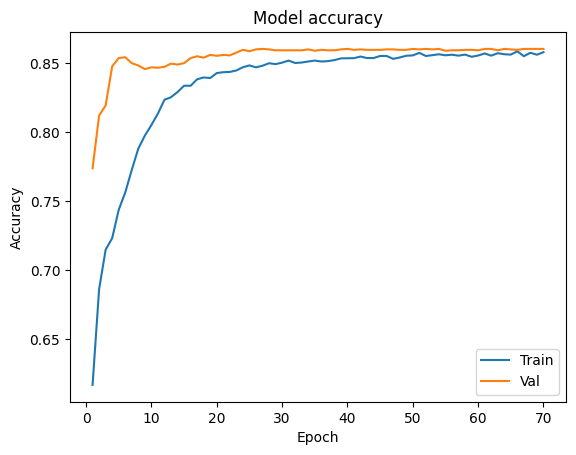

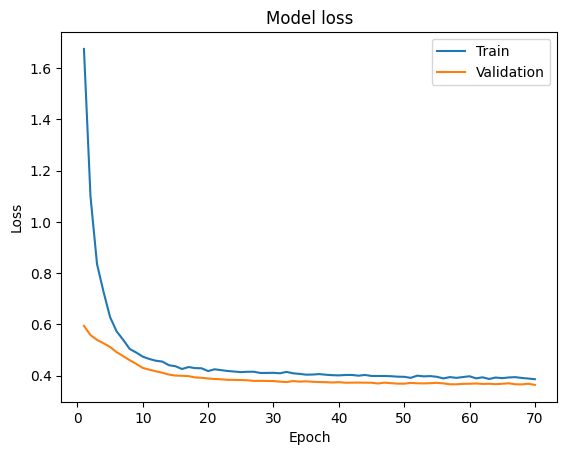

In [26]:
plot_learningCurve(history, epochs)

In [27]:
#evaluating the model
results = CNN.evaluate(X_test_reshaped, y_test)
test_loss, accuracy, precision, recall, auc = results
print(f"Test loss:{test_loss}") #the difference between the model's prediction and the target value
print(f"Accuracy:{accuracy}")   #measures the correctly predicted instances out of the total number of instances
print(f"Precision:{precision}") #measures how many correct positive were predicted out of all the positives
print(f"Recall:{recall}")   #measures the accuracy of positive predictions made by the model
print(f"AUC:{auc}")

94/94 [==============================] - 0s 3ms/step - loss: 0.3641 - accuracy: 0.8605 - precision: 0.9632 - recall: 0.7495 - auc: 0.8874
Test loss:0.36411046981811523
Accuracy:0.8604728579521179
Precision:0.9631849527359009
Recall:0.7495003342628479
AUC:0.8874183893203735


In [28]:
#generating the predictions
y_pred = y_pred_for_DLModels(CNN, X_test)

94/94 [==============================] - 0s 2ms/step


In [29]:
#F score
F1 = 2 * (precision * recall) / (precision + recall)
F1

0.8430123730408743

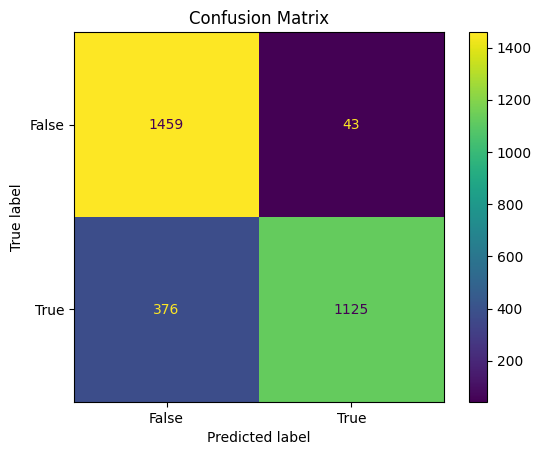

In [30]:
#Creating the confusion matrix using the test and predicted data.
actual = (y_test)
predicted = (y_pred)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

Epoch 1/70
47/47 [==============================] - 9s 30ms/step - loss: 1.2069 - accuracy: 0.5442 - precision_3: 0.5451 - recall_3: 0.5349 - auc_3: 0.5555 - val_loss: 0.6646 - val_accuracy: 0.6787 - val_precision_3: 0.6765 - val_recall_3: 0.6842 - val_auc_3: 0.7544
Epoch 2/70
47/47 [==============================] - 1s 11ms/step - loss: 0.8879 - accuracy: 0.5937 - precision_3: 0.5943 - recall_3: 0.5908 - auc_3: 0.6275 - val_loss: 0.6428 - val_accuracy: 0.7030 - val_precision_3: 0.7244 - val_recall_3: 0.6549 - val_auc_3: 0.7715
Epoch 3/70
47/47 [==============================] - 1s 11ms/step - loss: 0.7387 - accuracy: 0.6259 - precision_3: 0.6307 - recall_3: 0.6078 - auc_3: 0.6705 - val_loss: 0.6161 - val_accuracy: 0.7163 - val_precision_3: 0.7423 - val_recall_3: 0.6622 - val_auc_3: 0.7807
Epoch 4/70
47/47 [==============================] - 0s 11ms/step - loss: 0.6647 - accuracy: 0.6521 - precision_3: 0.6574 - recall_3: 0.6353 - auc_3: 0.7071 - val_loss: 0.5911 - val_accuracy: 0.7223 -

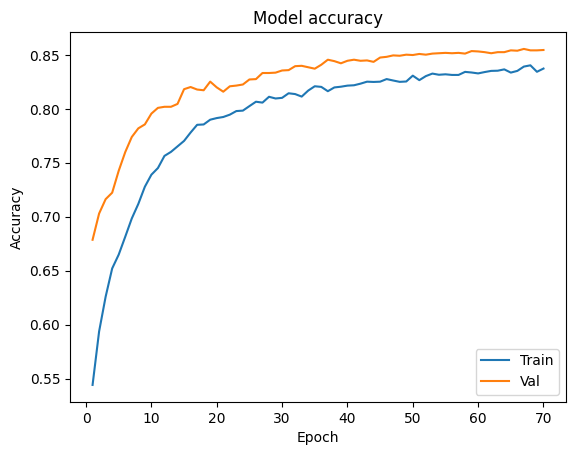

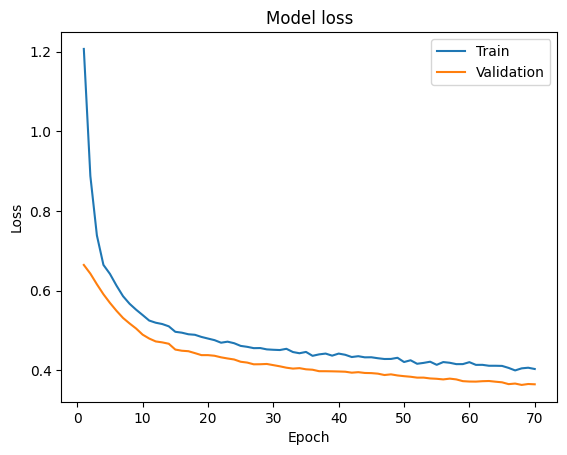

In [33]:
epochs = 70
CNN = Sequential()
CNN.add(Conv1D(32, 2, activation='relu', input_shape = X_train_reshaped[0].shape))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(2))
CNN.add(Dropout(0.2))

CNN.add(Conv1D(64, 2, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(2))
CNN.add(Dropout(0.7))

CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
CNN.add(Dropout(0.7
                ))

CNN.add(Dense(1, activation='sigmoid'))

CNN.compile(optimizer=Adam(), loss = 'binary_crossentropy', metrics=['accuracy',Precision(), Recall(), AUC()])
history = CNN.fit(X_train, y_train, epochs=epochs, batch_size=256 , validation_data=(X_test, y_test), verbose=1)
plot_learningCurve(history, epochs)